In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import uproot
%matplotlib inline

In [2]:
root_file = uproot.open("global_train.root")

In [4]:
root_file.keys()

[b'tree;1']

In [5]:
tree = root_file['tree']

In [8]:
cols = ['TrackP', 'TrackPt', 'RichDLLk', 'CaloEcalE', 'CaloHcalE', 'MCParticleType']

df = tree.pandas.df(cols)

In [25]:
kaons = df[df.MCParticleType.abs() == 321].copy()
pions = df[df.MCParticleType.abs() == 211].copy()

In [26]:
xcols = [col for col in cols if col != 'MCParticleType']

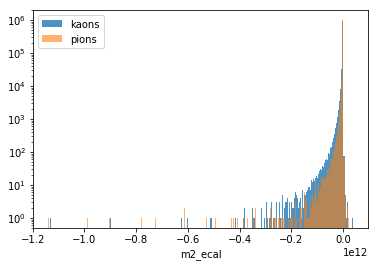

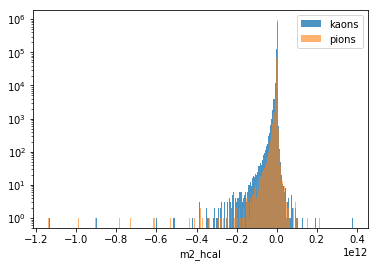

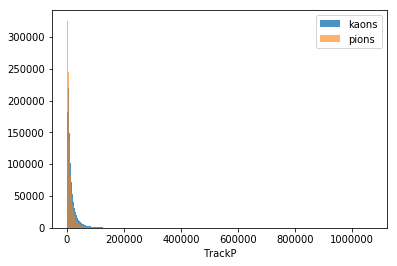

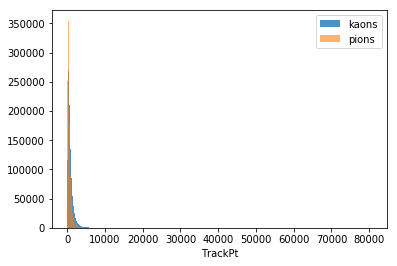

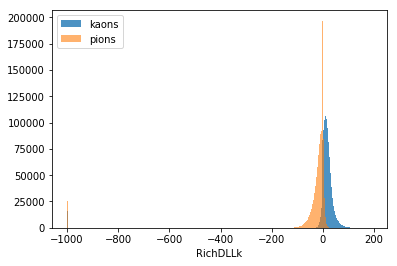

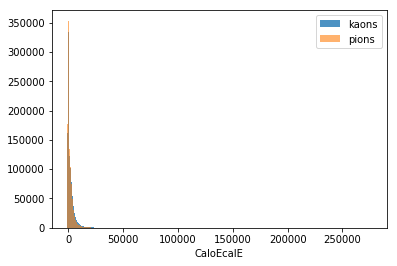

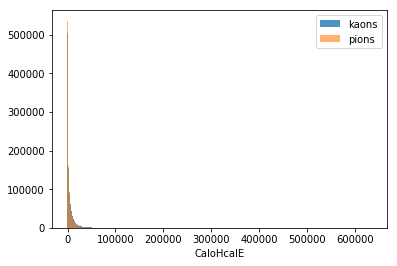

In [27]:
def draw_2cols(col_k, col_p, title, logy=False):
    l = min(col_k.min(), col_p.min())
    r = max(col_k.max(), col_p.max())
    bins = np.linspace(l, r, 301)
    plt.hist(col_k, bins=bins, alpha=0.8, label='kaons')
    plt.hist(col_p, bins=bins, alpha=0.6, label='pions')
    plt.legend()
    plt.xlabel(title)
    if logy:
        plt.yscale('log')
    plt.show()


draw_2cols(kaons.CaloEcalE**2 - kaons.TrackP**2,
           pions.CaloEcalE**2 - pions.TrackP**2,
           'm2_ecal', logy=True)

draw_2cols(kaons.CaloHcalE**2 - kaons.TrackP**2,
           pions.CaloHcalE**2 - pions.TrackP**2,
           'm2_hcal', logy=True)

for col in xcols:
    draw_2cols(kaons[col], pions[col], col)


In [22]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [28]:
kaons['is_kaon'] = 1
pions['is_kaon'] = 0

In [46]:
ds = pd.concat([kaons, pions], ignore_index=True)

In [47]:
np.random.seed(42)
ds = ds.iloc[np.random.permutation(len(ds))].reset_index(drop=True).copy()

In [49]:
train, test = train_test_split(ds, test_size=0.25)

In [50]:
print(roc_auc_score(train.is_kaon, train.RichDLLk))
print(roc_auc_score(test .is_kaon, test .RichDLLk))

0.9365811792843928
0.9364798581485219


In [51]:
xcols

['TrackP', 'TrackPt', 'RichDLLk', 'CaloEcalE', 'CaloHcalE']

In [57]:
from sklearn.preprocessing import RobustScaler

In [75]:
def features(x):
    return np.array([
        x['RichDLLk'],
        x['RichDLLk'] ** 2,
        x['CaloEcalE']**2 - x['TrackP']**2,
        x['CaloHcalE']**2 - x['TrackP']**2,
        x['CaloEcalE'],
        x['CaloHcalE'],
        x['TrackP'],
        x['TrackPt'],
        x['RichDLLk'] * x['CaloEcalE'],
        x['RichDLLk'] * x['CaloHcalE'],
        x['RichDLLk'] * x['TrackP'],
        x['RichDLLk'] * x['TrackPt'],
    ]).T

scaler = RobustScaler()
model = LogisticRegression()
scaler.fit(features(train))
model.fit(scaler.transform(features(train)), train.is_kaon)

preds_train = model.predict_proba(scaler.transform(features(train)))[:,1]
preds_test  = model.predict_proba(scaler.transform(features(test )))[:,1]

print(roc_auc_score(train.is_kaon, preds_train))
print(roc_auc_score(test .is_kaon, preds_test ))

/mnt/amaevskiy/conda_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9489486494485975
0.9488013955547353


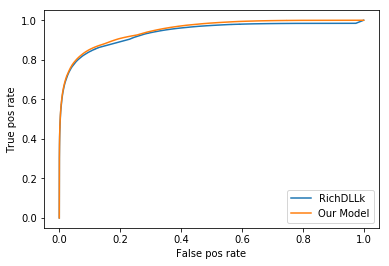

In [77]:
fpr_dll, tpr_dll, _ = roc_curve(test.is_kaon, test.RichDLLk)
fpr_mod, tpr_mod, _ = roc_curve(test.is_kaon, preds_test)

plt.plot(fpr_dll, tpr_dll, label='RichDLLk')
plt.plot(fpr_mod, tpr_mod, label='Our Model')
plt.legend()
plt.xlabel('False pos rate')
plt.ylabel('True pos rate')

plt.show();